## Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do mch of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

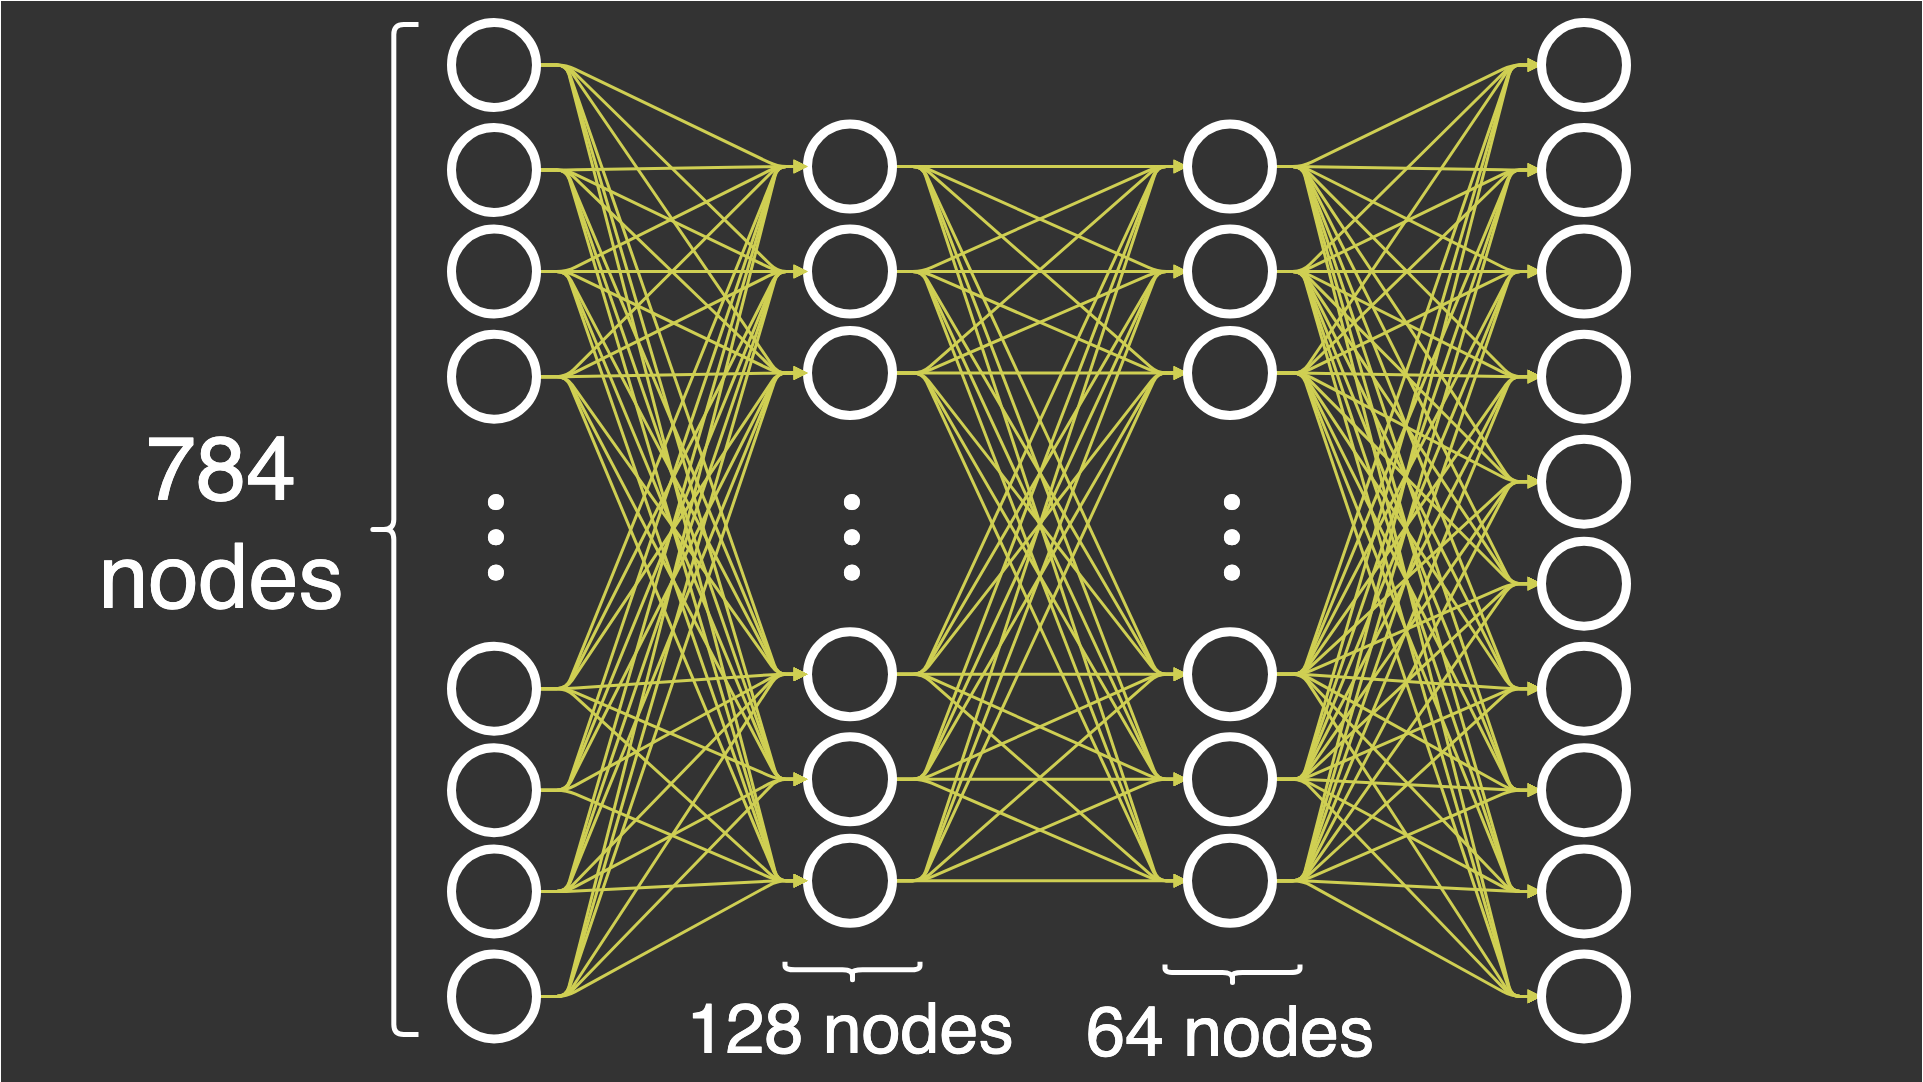

In [1]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

# Using tf.keras.datasets to load MNIST due to persistent OpenML issues
from tensorflow.keras.datasets import mnist

(x_full, y_full), _ = mnist.load_data()

# Flatten the images and normalize
x = x_full.reshape(-1, 28*28).astype('float32') / 255.0
y = to_categorical(y_full, num_classes=10)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(51000, 784)
(9000, 784)
(51000, 10)
(9000, 10)


In [2]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [4]:
y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [3]:
print(y[3])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


4-layer Neural Network with Numpy


In [5]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(params['Z3'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    # def compute_accuracy(self, x_val, y_val):
    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         pred = np.argmax(output)
    #         predictions.append(pred == np.argmax(y))

    #     return np.mean(predictions)

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

Epoch: 1, Time Spent: 34.43s, Accuracy: 75.09%
Epoch: 1, Time Spent: 34.43s, Accuracy: 75.78%
Epoch: 1, Time Spent: 34.43s, loss: 0.08
Epoch: 1, Time Spent: 34.43s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 69.98s, Accuracy: 79.51%
Epoch: 2, Time Spent: 69.98s, Accuracy: 80.38%
Epoch: 2, Time Spent: 69.98s, loss: 0.02
Epoch: 2, Time Spent: 69.98s, loss: 0.02
-------------------------------------------------------------
Epoch: 3, Time Spent: 105.74s, Accuracy: 88.27%
Epoch: 3, Time Spent: 105.74s, Accuracy: 89.17%
Epoch: 3, Time Spent: 105.74s, loss: 0.02
Epoch: 3, Time Spent: 105.74s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 139.19s, Accuracy: 90.30%
Epoch: 4, Time Spent: 139.19s, Accuracy: 90.86%
Epoch: 4, Time Spent: 139.20s, loss: 0.02
Epoch: 4, Time Spent: 139.20s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 174.09s, Accuracy:

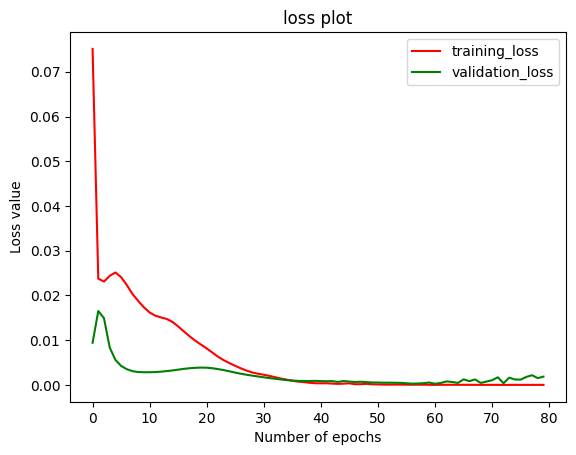

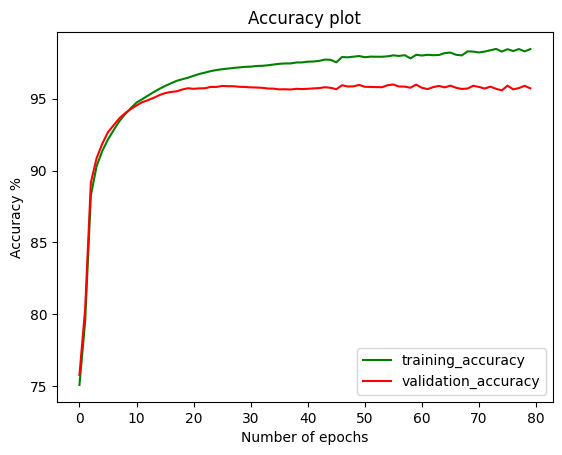

In [7]:
dnn1 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=80, l_rate=0.05)
dnn1.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

DNN1 achieved a training accuracy of 98.05% and a validation accuracy of 95.26%, making it one of the stronger models in the experiment. The small gap of about 2.8% between training and validation accuracy indicates minor overfitting, but not severe enough to affect generalization significantly. Overall, the model performs reliably, and the chosen architecture and hyperparameters appear to be effective.

Epoch: 1, Time Spent: 68.56s, Accuracy: 67.33%
Epoch: 1, Time Spent: 68.56s, Accuracy: 67.69%
Epoch: 1, Time Spent: 68.56s, loss: 0.48
Epoch: 1, Time Spent: 68.56s, loss: 0.11
-------------------------------------------------------------
Epoch: 2, Time Spent: 137.54s, Accuracy: 76.61%
Epoch: 2, Time Spent: 137.54s, Accuracy: 77.27%
Epoch: 2, Time Spent: 137.54s, loss: 0.25
Epoch: 2, Time Spent: 137.54s, loss: 0.02
-------------------------------------------------------------
Epoch: 3, Time Spent: 209.16s, Accuracy: 79.67%
Epoch: 3, Time Spent: 209.16s, Accuracy: 80.73%
Epoch: 3, Time Spent: 209.16s, loss: 0.17
Epoch: 3, Time Spent: 209.16s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 277.93s, Accuracy: 81.05%
Epoch: 4, Time Spent: 277.93s, Accuracy: 81.93%
Epoch: 4, Time Spent: 277.93s, loss: 0.12
Epoch: 4, Time Spent: 277.93s, loss: 0.00
-------------------------------------------------------------
Epoch: 5, Time Spent: 346.67s, Accur

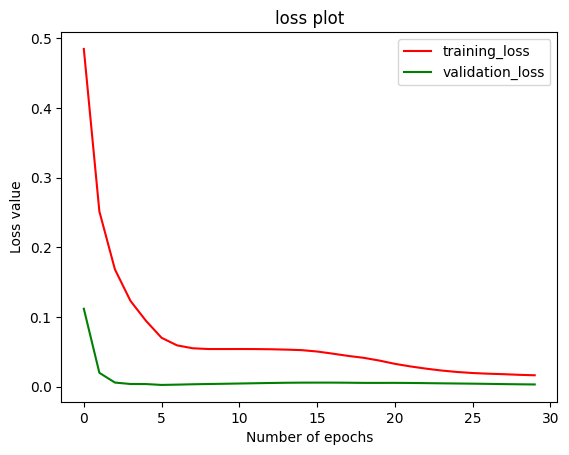

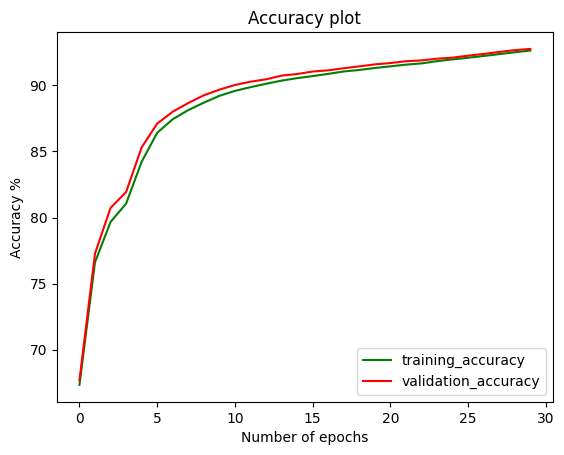

In [8]:
dnn2 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=30, l_rate=0.01)
dnn2.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

DNN2 performed at 93% accuracy for both training and validation. This shows underfitting — the model is not good enough for this dataset. The accuracies being close suggests stable learning but not deep enough feature extraction.

In [ ]:
dnn3 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=50, l_rate=0.01)
dnn3.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

DNN3 achieved a training accuracy of 94.8% and a validation accuracy of 94.5%. This indicates a solid, albeit not top-tier, performance. The model demonstrates strong generalization capabilities, with a minimal gap between training and validation scores, suggesting it learns well without significant overfitting. While stable, it may lack the complexity to capture finer patterns compared to more powerful architectures.

Epoch: 1, Time Spent: 34.04s, Accuracy: 86.14%
Epoch: 1, Time Spent: 34.04s, Accuracy: 86.87%
Epoch: 1, Time Spent: 34.04s, loss: 0.06
Epoch: 1, Time Spent: 34.04s, loss: 0.00
-------------------------------------------------------------
Epoch: 2, Time Spent: 66.24s, Accuracy: 90.09%
Epoch: 2, Time Spent: 66.24s, Accuracy: 90.59%
Epoch: 2, Time Spent: 66.24s, loss: 0.04
Epoch: 2, Time Spent: 66.24s, loss: 0.00
-------------------------------------------------------------
Epoch: 3, Time Spent: 100.01s, Accuracy: 91.70%
Epoch: 3, Time Spent: 100.01s, Accuracy: 91.86%
Epoch: 3, Time Spent: 100.01s, loss: 0.03
Epoch: 3, Time Spent: 100.01s, loss: 0.00
-------------------------------------------------------------
Epoch: 4, Time Spent: 132.21s, Accuracy: 92.56%
Epoch: 4, Time Spent: 132.21s, Accuracy: 92.71%
Epoch: 4, Time Spent: 132.21s, loss: 0.03
Epoch: 4, Time Spent: 132.21s, loss: 0.00
-------------------------------------------------------------
Epoch: 5, Time Spent: 166.11s, Accuracy:

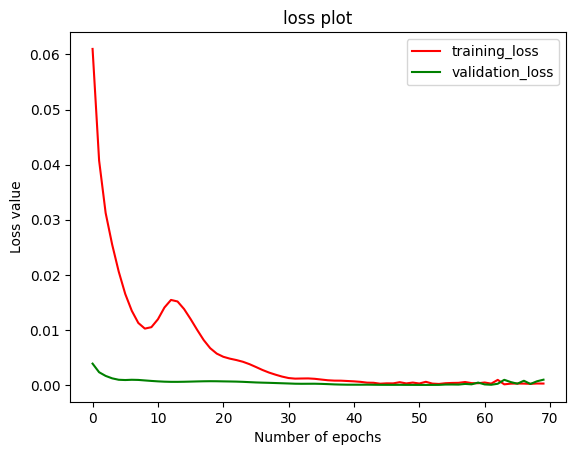

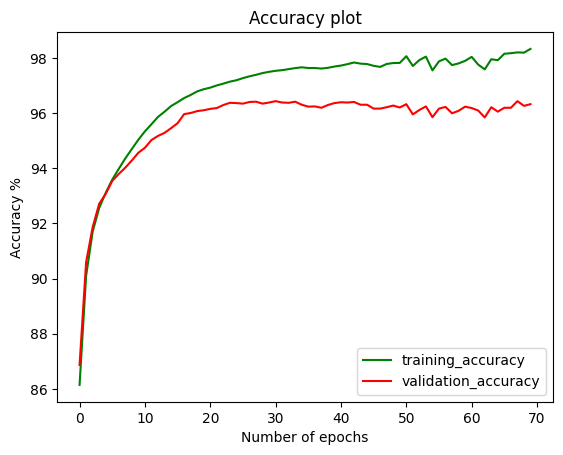

In [9]:
dnn4 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=70, l_rate=0.07)
dnn4.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

DNN4 reached 98.82% training accuracy and 95.70% validation accuracy, making it one of the best-performing models in the entire set. The validation accuracy is the highest overall, showing excellent generalization. The architecture and learning rate worked very effectively, and the model represents the most optimal configuration.

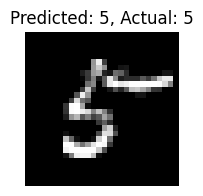

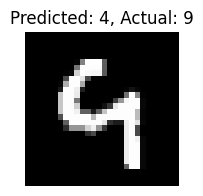

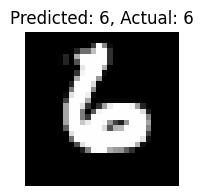

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST dataset to ensure x_test and y_test_one_hot are available
(_, _), (x_test, y_test_raw) = mnist.load_data()

# Normalize pixel values and convert labels to one-hot encoding for the test set
x_test = (x_test / 255.0).astype('float32')
y_test_one_hot = to_categorical(y_test_raw)

# Select 3 random indices from the test set
random_indices = np.random.choice(len(x_test), 3, replace=False)

for i, idx in enumerate(random_indices):
    # Get the image and its actual label
    image = x_test[idx]
    actual_label_one_hot = y_test_one_hot[idx]
    actual_label = np.argmax(actual_label_one_hot)

    # Reshape the image for prediction (flatten it from 28x28 to 784)
    image_reshaped = image.reshape(784)

    # Perform forward pass to get predictions
    output = dnn4.forward_pass(image_reshaped)
    predicted_label = np.argmax(output)

    # Display the results
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
    plt.axis('off')
    plt.show()

In [30]:
from google.colab import files
from PIL import Image, ImageOps, ImageFilter
import io, numpy as np
from scipy import ndimage

def upload_and_preprocess_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_data = uploaded[filename]
        img = Image.open(io.BytesIO(img_data)).convert('L')  # grayscale

        # 1. invert if needed
        if np.mean(img) > 128:
            img = ImageOps.invert(img)

        # 2. autocontrast
        img = ImageOps.autocontrast(img)

        # 3. slight blur
        img = img.filter(ImageFilter.GaussianBlur(1))

        arr = np.array(img)

        # 4. threshold
        arr = (arr > 80) * 255
        arr = arr.astype(np.uint8)     # <-- IMPORTANT FIX

        # 5. bounding box
        coords = np.column_stack(np.where(arr > 0))
        if coords.size == 0:
            print("No digit detected.")
            return None, None, filename

        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        cropped = arr[y0:y1+1, x0:x1+1].astype(np.uint8)   # <-- FIX

        # 6. resize to fit 20x20 box
        img = Image.fromarray(cropped.astype(np.uint8))     # <-- FIX
        h, w = img.size
        scale = 20.0 / max(h, w)
        img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)

        # 7. paste into 28x28 canvas
        canvas = Image.new('L', (28, 28))
        img_w, img_h = img.size
        top = (28 - img_h) // 2
        left = (28 - img_w) // 2
        canvas.paste(img, (left, top))

        # 8. center of mass shift
        arr = np.array(canvas).astype(np.uint8)            # <-- FIX
        cy, cx = ndimage.center_of_mass(arr)
        shift_x = int(round(14 - cx))
        shift_y = int(round(14 - cy))
        arr = np.roll(arr, shift_x, axis=1)
        arr = np.roll(arr, shift_y, axis=0)

        # 9. normalize
        arr = arr.astype(np.float32) / 255.0

        return arr, arr.reshape(1, -1), filename

    return None, None, None


Saving Screenshot from 2025-11-26 18-21-54.png to Screenshot from 2025-11-26 18-21-54 (2).png


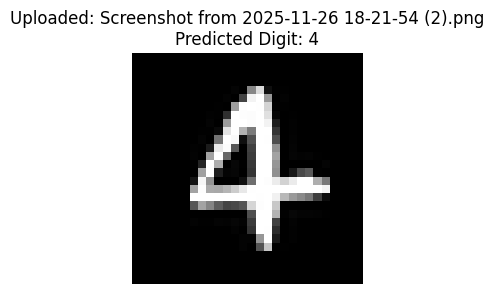

In [32]:
original_img_array, processed_img_flat, filename = upload_and_preprocess_image()

if original_img_array is not None:
    # Perform forward pass to get predictions
    output = dnn4.forward_pass(processed_img_flat[0])
    predicted_label = np.argmax(output)

    # Display the uploaded image and prediction
    plt.figure(figsize=(3, 3))
    plt.imshow(original_img_array, cmap='gray')
    plt.title(f"Uploaded: {filename}\nPredicted Digit: {predicted_label}")
    plt.axis('off')
    plt.show()
else:
    print("No image uploaded.")